# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(df['smoking_status'].unique())
print(df['gender'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())

['formerly smoked' 'never smoked' 'smokes' 'Unknown']
['Male' 'Female' 'Other']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

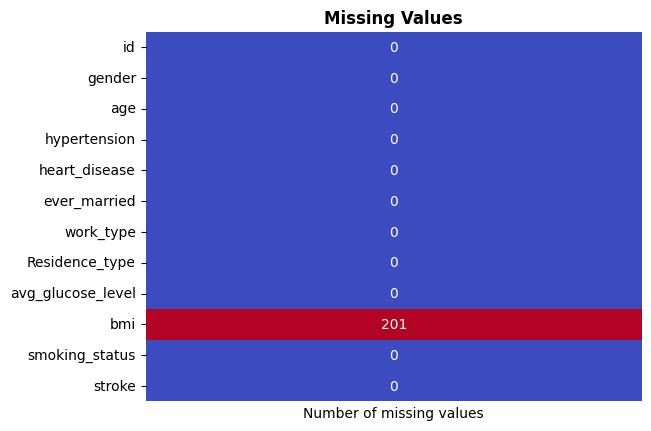

In [6]:
plt.title('Missing Values', fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', cbar=False)
ax.set_xlabel('Number of missing values')
ax.set_xticks([])
plt.show()

## Fill gaps

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [8]:
DTR_bmi_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('DTR', DecisionTreeRegressor(random_state=42))])
X_bmi = df[['age','gender','bmi']].copy()
X_bmi.gender = X_bmi.gender.replace({'Male': 0,'Female': 1,'Other': -1}).astype(np.uint8)

X_with_missing_bmis = X_bmi[X_bmi.bmi.isna()]
X_bmi = X_bmi[~X_bmi.bmi.isna()]
y_bmi = X_bmi.pop('bmi')
DTR_bmi_pipe.fit(X_bmi, y_bmi)
predicted_bmis = pd.Series(DTR_bmi_pipe.predict(X_with_missing_bmis[['age','gender']]), index=X_with_missing_bmis.index)
df.loc[X_with_missing_bmis.index, 'bmi'] = predicted_bmis

In [9]:
print('Overall number of missing values: ', sum(df.isnull().sum()))

Overall number of missing values:  0


# Model preparation

## Encode categorical values

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [11]:
df['ever_married'] = LabelEncoder().fit_transform(df['ever_married'])
df['Residence_type'] = LabelEncoder().fit_transform(df['Residence_type'])
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['work_type'] = LabelEncoder().fit_transform(df['work_type'])
df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])
# df = TargetEncoder().fit_transform(df, df['stroke'])

In [12]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,29.879487,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [13]:
print(df['smoking_status'].unique())
print(df['gender'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())

[1 2 3 0]
[1 0 2]
[2 3 0 4 1]
[1 0]


In [14]:
corr = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']].corr()

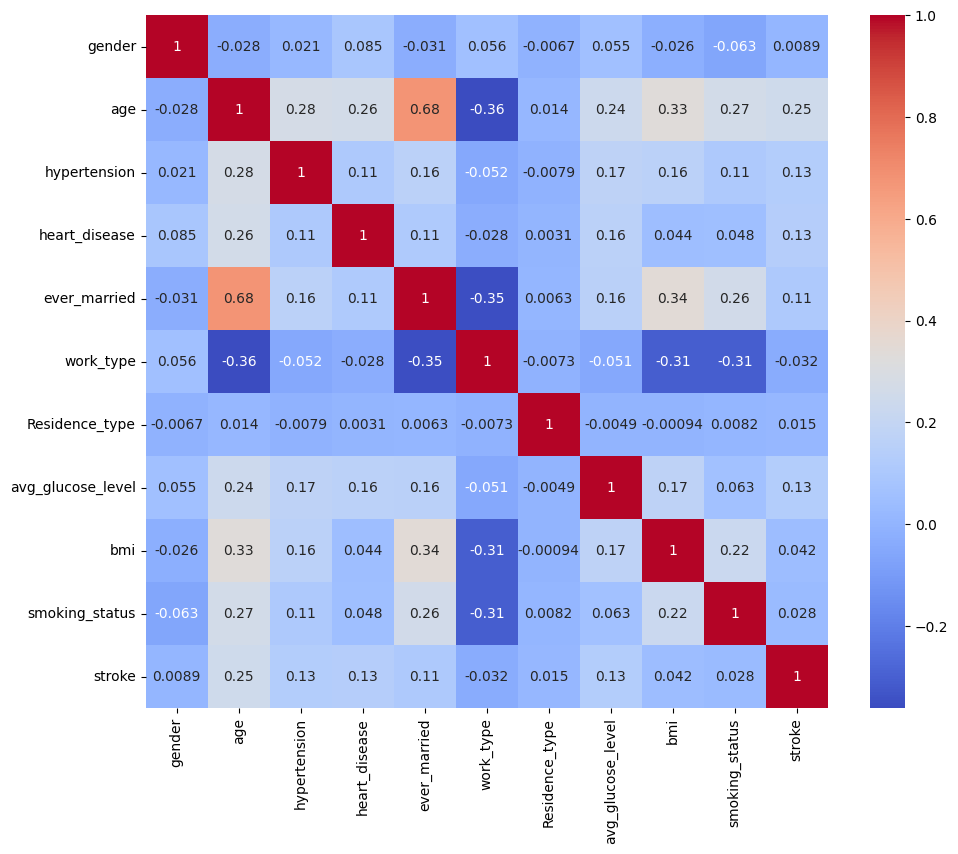

In [15]:
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.xticks(rotation=90)
plt.show()

## Split dataset into train and test sets

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y = df['stroke']
X = df.drop(columns=['stroke', 'id', "ever_married"])

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='minority')
# X, y = sm.fit_resample(X, y)

# from imblearn.over_sampling import SMOTE
# oversampler = SMOTE()

# i,X_test_init, j, y_test_init = train_test_split(X, y, test_size=0.2, random_state=42)

# X, y = oversampler.fit_resample(X,y)
# X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)
# X_train_res = X_train
# y_train_res = y_train

## Balance dataset

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [20]:
X_train_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7802 non-null   int32  
 1   age                7802 non-null   float64
 2   hypertension       7802 non-null   int64  
 3   heart_disease      7802 non-null   int64  
 4   work_type          7802 non-null   int32  
 5   Residence_type     7802 non-null   int32  
 6   avg_glucose_level  7802 non-null   float64
 7   bmi                7802 non-null   float64
 8   smoking_status     7802 non-null   int32  
dtypes: float64(3), int32(4), int64(2)
memory usage: 426.8 KB


<Axes: xlabel='stroke', ylabel='count'>

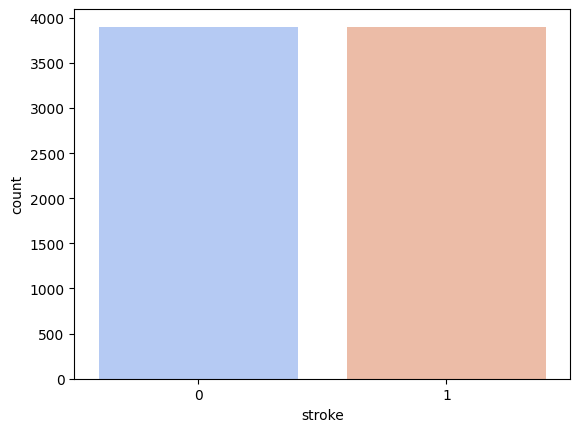

In [21]:
sns.countplot(x=y_train_res, palette='coolwarm')

# Building models

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

In [23]:
def test_models(X_train, y_train, X_test, y_test):
    models = [['KNearest Neighbor ',KNeighborsClassifier(leaf_size=1, n_neighbors=14, p=2)],
              ['Decision Tree Classifier ',DecisionTreeClassifier()],
              ['Random Forest Classifier ',RandomForestClassifier()],
              ['Ada Boost ',AdaBoostClassifier()],
              ['SVM ',SVC()],
              ['XG Boost',XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=100)],
              ['Cat Boost',CatBoostClassifier(logging_level='Silent')]]

    models_scores = []
    for name, model in models:

        curr_model = model
        curr_model.fit(X_train, y_train)
        curr_model_pred = curr_model.predict(X_test)
        cm_model = confusion_matrix(y_test, curr_model_pred)
        models_scores.append((name, accuracy_score(y_test, curr_model_pred), f1_score(y_test, curr_model_pred)))

        plt.title(name)
        sns.heatmap(confusion_matrix(y_test, curr_model_pred), annot=True, fmt='g', cmap='coolwarm', cbar=False, 
            yticklabels=['Actual non-stroke', 'Actual Stroke'], xticklabels=['Predicted non-stroke', 'Predicted stroke'])
        
        plt.show()
        
        print(classification_report(y_test, curr_model_pred))
        print('Accuracy Score: ', accuracy_score(y_test, curr_model_pred))
        print('F1 Score: ', f1_score(y_test, curr_model_pred))
        
    return models_scores

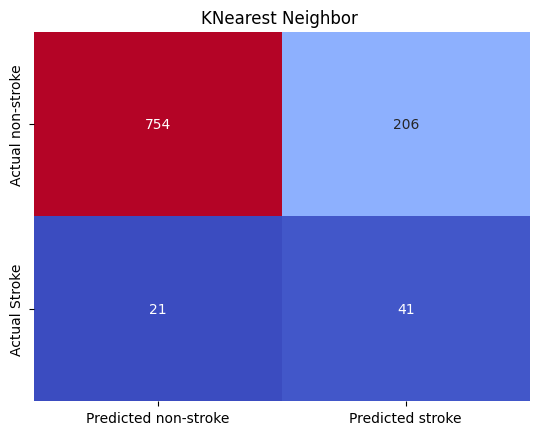

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       960
           1       0.17      0.66      0.27        62

    accuracy                           0.78      1022
   macro avg       0.57      0.72      0.57      1022
weighted avg       0.92      0.78      0.83      1022

Accuracy Score:  0.7778864970645792
F1 Score:  0.26537216828478966


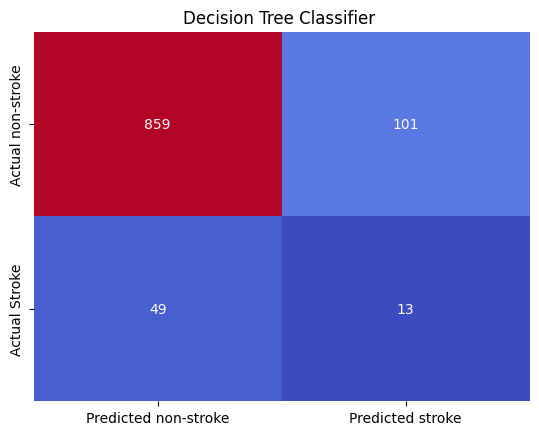

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       960
           1       0.11      0.21      0.15        62

    accuracy                           0.85      1022
   macro avg       0.53      0.55      0.53      1022
weighted avg       0.90      0.85      0.87      1022

Accuracy Score:  0.8532289628180039
F1 Score:  0.14772727272727273


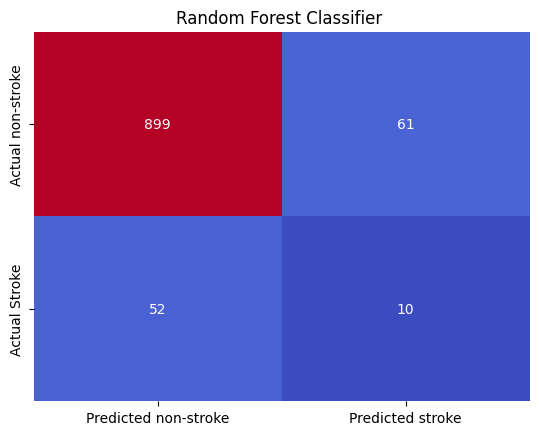

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       960
           1       0.14      0.16      0.15        62

    accuracy                           0.89      1022
   macro avg       0.54      0.55      0.55      1022
weighted avg       0.90      0.89      0.89      1022

Accuracy Score:  0.8894324853228963
F1 Score:  0.15037593984962408


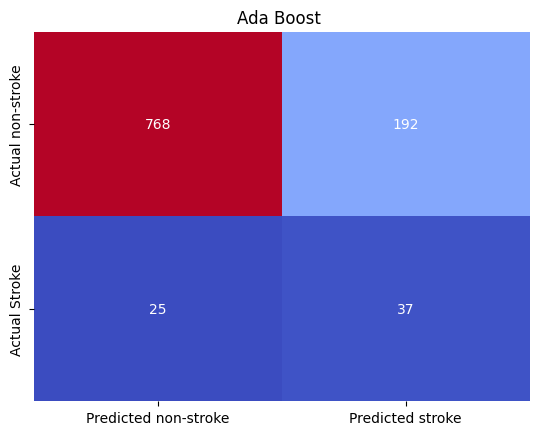

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       960
           1       0.16      0.60      0.25        62

    accuracy                           0.79      1022
   macro avg       0.57      0.70      0.57      1022
weighted avg       0.92      0.79      0.84      1022

Accuracy Score:  0.7876712328767124
F1 Score:  0.25429553264604815


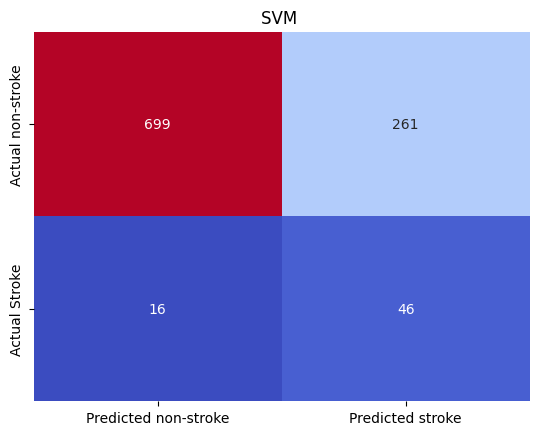

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       960
           1       0.15      0.74      0.25        62

    accuracy                           0.73      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.93      0.73      0.80      1022

Accuracy Score:  0.7289628180039139
F1 Score:  0.24932249322493225


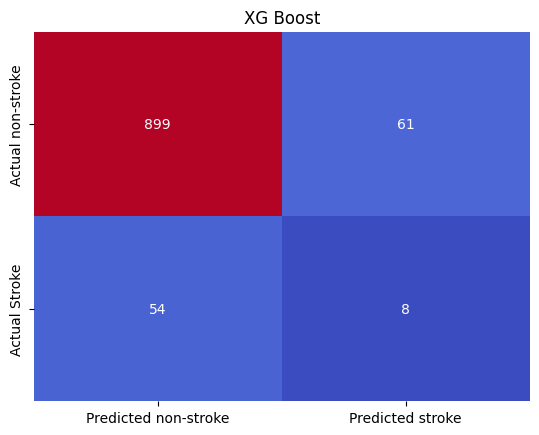

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       960
           1       0.12      0.13      0.12        62

    accuracy                           0.89      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.89      0.89      0.89      1022

Accuracy Score:  0.8874755381604696
F1 Score:  0.12213740458015265


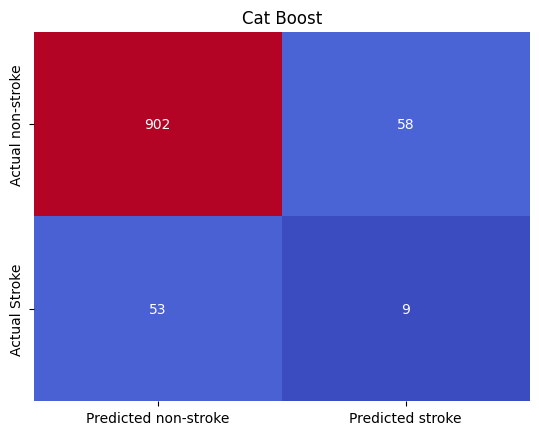

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       960
           1       0.13      0.15      0.14        62

    accuracy                           0.89      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.90      0.89      0.89      1022

Accuracy Score:  0.8913894324853229
F1 Score:  0.13953488372093023


In [24]:
models_scores = test_models(X_train_res, y_train_res, X_test, y_test)

In [25]:
print(models_scores)

[('KNearest Neighbor ', 0.7778864970645792, 0.26537216828478966), ('Decision Tree Classifier ', 0.8532289628180039, 0.14772727272727273), ('Random Forest Classifier ', 0.8894324853228963, 0.15037593984962408), ('Ada Boost ', 0.7876712328767124, 0.25429553264604815), ('SVM ', 0.7289628180039139, 0.24932249322493225), ('XG Boost', 0.8874755381604696, 0.12213740458015265), ('Cat Boost', 0.8913894324853229, 0.13953488372093023)]


In [26]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()
#clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#best_model = clf.fit(X, y)

#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])